In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 41047066.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112894402.45it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44327806.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22255290.62it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


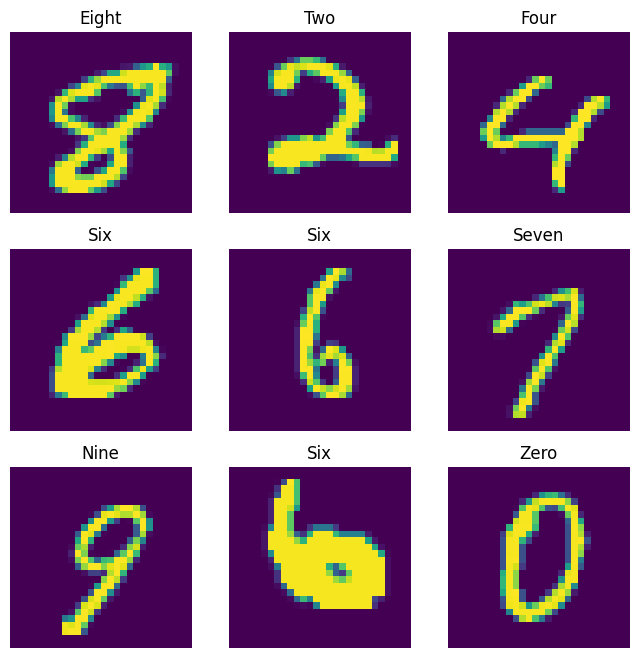

In [ ]:

labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    print(img.size())
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=8192, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8192, shuffle=True)

In [ ]:
class Classifier_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 5, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(980, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

In [ ]:
model_0=Classifier_cnn()
device='cuda'
print(f"Using Device: {device}")
model_0=model_0.to(device)
print(model_0)

Using Device: cuda
Classifier_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=980, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),lr=0.01)

In [ ]:
def accuracy_fn(y_preds,y_true):
  accuracy = ((torch.softmax(y_preds, dim=1).argmax(dim=1) == y_true).sum().float() / float( y_true.size(0) ))*100
  return accuracy

In [ ]:
epochs=20

train_losses=[]
train_accuracies=[]
test_losses=[]
test_accuracies=[]
epoch_iter=[]
for epoch in range(epochs):
  tr_l=[]
  te_l=[]
  tr_a=[]
  te_a=[]
  for i,data in enumerate(train_dataloader):
    #TRAINING
    model_0.train()
    X_train, train_labels = data
    #X_train=torch.flatten(train_features,start_dim=1,end_dim=-1).to(device)
    #Y_train=torch.nn.functional.one_hot(train_labels.to(torch.long),num_classes=10).to(device)

    #Forward
    #print(X_train.size())
    Y_train_preds=model_0(X_train.to(device))
    #print(Y_train_preds[0])
    #Loss
    #print(Y_train_preds)
    train_loss=loss_fn(Y_train_preds.to(device),train_labels.to(device))
    #Zero grad
    optimizer.zero_grad()
    #Backward
    train_loss.backward()
    #Update
    optimizer.step()
    train_accuracy=accuracy_fn(Y_train_preds.to(device),train_labels.to(device))

    #TESTING
    model_0.eval()
    tr_l.append(train_loss.cpu().detach().numpy())
    tr_a.append(train_accuracy.cpu().detach().numpy())
  for i,data in enumerate(test_dataloader):
    X_test, test_labels = data
    #X_test=torch.flatten(test_features,start_dim=1,end_dim=-1).to(device)
    #Y_test=torch.nn.functional.one_hot(test_labels.to(torch.long),num_classes=10).to(device)
    with torch.inference_mode():
      Y_test_preds=model_0(X_test.to(device))
      test_loss=loss_fn(Y_test_preds.to(device),test_labels.to(device))
      test_accuracy=accuracy_fn(Y_test_preds.to(device),test_labels.to(device))
    te_l.append(test_loss.cpu().detach().numpy())
    te_a.append(test_accuracy.cpu().detach().numpy())

  train_losses.append(sum(tr_l)/len(tr_l))
  test_losses.append(sum(te_l)/len(te_l))
  train_accuracies.append(sum(tr_a)/len(tr_a))
  test_accuracies.append(sum(te_a)/len(te_a))


  if epoch%(int(epochs/10))==0:
    print(f"Epoch: {epoch} | Train Loss: {train_losses[epoch]:.5f} Train Accuracy: {train_accuracies[epoch]:.3f} | Test Loss: {test_losses[epoch]:.5f} | Test Accuracy: {test_accuracies[epoch]:.3f}")




Epoch: 0 | Train Loss: 1.48844 Train Accuracy: 48.923 | Test Loss: 0.58562 | Test Accuracy: 81.972
Epoch: 2 | Train Loss: 0.27962 Train Accuracy: 91.856 | Test Loss: 0.16783 | Test Accuracy: 95.256
Epoch: 4 | Train Loss: 0.13929 Train Accuracy: 95.768 | Test Loss: 0.08693 | Test Accuracy: 97.158
Epoch: 6 | Train Loss: 0.09649 Train Accuracy: 97.109 | Test Loss: 0.05837 | Test Accuracy: 98.089
Epoch: 8 | Train Loss: 0.07165 Train Accuracy: 97.728 | Test Loss: 0.04841 | Test Accuracy: 98.346
Epoch: 10 | Train Loss: 0.05843 Train Accuracy: 98.166 | Test Loss: 0.04169 | Test Accuracy: 98.646
Epoch: 12 | Train Loss: 0.04889 Train Accuracy: 98.462 | Test Loss: 0.03790 | Test Accuracy: 98.778
Epoch: 14 | Train Loss: 0.04104 Train Accuracy: 98.671 | Test Loss: 0.03519 | Test Accuracy: 98.769
Epoch: 16 | Train Loss: 0.03679 Train Accuracy: 98.810 | Test Loss: 0.03112 | Test Accuracy: 99.051
Epoch: 18 | Train Loss: 0.03166 Train Accuracy: 98.992 | Test Loss: 0.03146 | Test Accuracy: 98.937


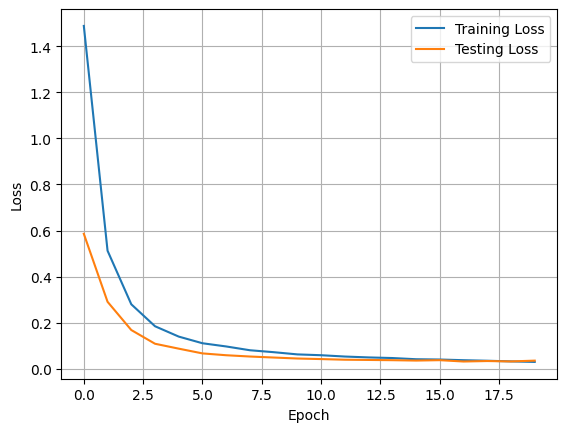

In [ ]:
plt.plot(train_losses,"-",label="Training Loss")
plt.plot(test_losses,label='Testing Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

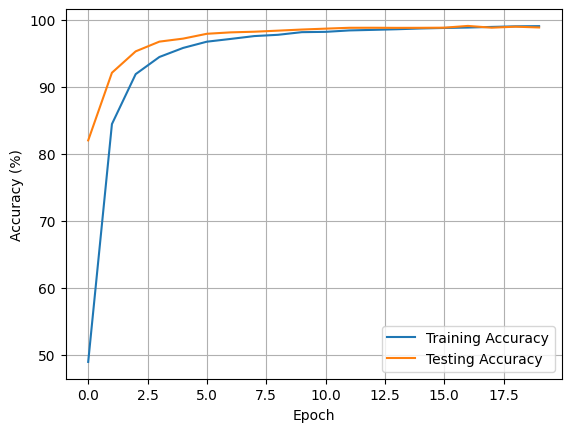

In [ ]:
plt.plot(train_accuracies,"-",label="Training Accuracy")
plt.plot(test_accuracies,label='Testing Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

torch.Size([1, 1, 28, 28])


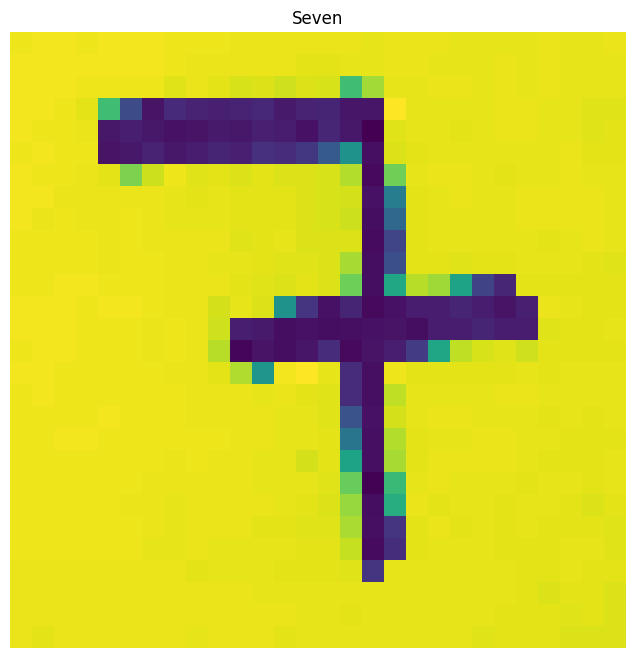

In [ ]:
import cv2
image=cv2.imread("/content/download.jpg",0)
image=cv2.resize(image,(28,28))
image=torch.tensor([[image]],dtype=torch.float32)
print(image.size())
predictions=model_0(image.to(device)).cpu()
prediction=labels_map[int((torch.softmax(predictions, dim=1).argmax(dim=1)))]
figure = plt.figure(figsize=(8, 8))
plt.title(prediction)
plt.axis("off")
plt.imshow(image.squeeze())